<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 15px; height: 80px">

# Project 3

### Regression and Classification with the Ames Housing Data

---

You have just joined a new "full stack" real estate company in Ames, Iowa. The strategy of the firm is two-fold:
- Own the entire process from the purchase of the land all the way to sale of the house, and anything in between.
- Use statistical analysis to optimize investment and maximize return.

The company is still small, and though investment is substantial the short-term goals of the company are more oriented towards purchasing existing houses and flipping them as opposed to constructing entirely new houses. That being said, the company has access to a large construction workforce operating at rock-bottom prices.

This project uses the [Ames housing data recently made available on kaggle](https://www.kaggle.com/c/house-prices-advanced-regression-techniques).

In [1]:
import numpy as np
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

sns.set_style('whitegrid')

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

<img src="http://imgur.com/l5NasQj.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 1. Estimating the value of homes from fixed characteristics.

---

Your superiors have outlined this year's strategy for the company:
1. Develop an algorithm to reliably estimate the value of residential houses based on *fixed* characteristics.
2. Identify characteristics of houses that the company can cost-effectively change/renovate with their construction team.
3. Evaluate the mean dollar value of different renovations.

Then we can use that to buy houses that are likely to sell for more than the cost of the purchase plus renovations.

Your first job is to tackle #1. You have a dataset of housing sale data with a huge amount of features identifying different aspects of the house. The full description of the data features can be found in a separate file:

    housing.csv
    data_description.txt
    
You need to build a reliable estimator for the price of the house given characteristics of the house that cannot be renovated. Some examples include:
- The neighborhood
- Square feet
- Bedrooms, bathrooms
- Basement and garage space

and many more. 

Some examples of things that **ARE renovate-able:**
- Roof and exterior features
- "Quality" metrics, such as kitchen quality
- "Condition" metrics, such as condition of garage
- Heating and electrical components

and generally anything you deem can be modified without having to undergo major construction on the house.

---

**Your goals:**
1. Perform any cleaning, feature engineering, and EDA you deem necessary.
- Be sure to remove any houses that are not residential from the dataset.
- Identify **fixed** features that can predict price.
- Train a model on pre-2010 data and evaluate its performance on the 2010 houses.
- Characterize your model. How well does it perform? What are the best estimates of price?

> **Note:** The EDA and feature engineering component to this project is not trivial! Be sure to always think critically and creatively. Justify your actions! Use the data description file!

In [2]:
# Load the data
house = pd.read_csv('./housing.csv')

In [3]:
# A:read the data

house.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [4]:
#check the data shape

house.shape

(1460, 81)

### Remove non-residential house from the dataset 

In [5]:
house.MSZoning.value_counts()

RL         1151
RM          218
FV           65
RH           16
C (all)      10
Name: MSZoning, dtype: int64

In [6]:
residential = house[house.MSZoning != 'C (all)']

In [7]:
residential.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [8]:
# Check the year sold value 

residential.YrSold.value_counts()

2009    336
2007    328
2006    312
2008    302
2010    172
Name: YrSold, dtype: int64

In [9]:
# check the null value 

null_columns = residential.isnull().sum()[residential.isnull().sum()>0].sort_values()

null_columns

Electrical         1
MasVnrType         8
MasVnrArea         8
BsmtQual          37
BsmtCond          37
BsmtFinType1      37
BsmtExposure      38
BsmtFinType2      38
GarageCond        79
GarageQual        79
GarageFinish      79
GarageType        79
GarageYrBlt       79
LotFrontage      259
FireplaceQu      681
Fence           1172
Alley           1361
MiscFeature     1398
PoolQC          1443
dtype: int64

In [10]:
# drop the ID column because the information does not correlated with the price value. Columns PoolQC, MiscFeature, Alley, Fence and FireplaceQu also being dropped because they have over 500 null values. 

residential = residential.drop(['Id', 'PoolQC', 'MiscFeature', 'Alley', 'Fence', 'FireplaceQu'], axis=1)

In [11]:
residential

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,...,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,60,RL,65.0,8450,Pave,Reg,Lvl,AllPub,Inside,Gtl,...,0,0,0,0,0,2,2008,WD,Normal,208500
1,20,RL,80.0,9600,Pave,Reg,Lvl,AllPub,FR2,Gtl,...,0,0,0,0,0,5,2007,WD,Normal,181500
2,60,RL,68.0,11250,Pave,IR1,Lvl,AllPub,Inside,Gtl,...,0,0,0,0,0,9,2008,WD,Normal,223500
3,70,RL,60.0,9550,Pave,IR1,Lvl,AllPub,Corner,Gtl,...,272,0,0,0,0,2,2006,WD,Abnorml,140000
4,60,RL,84.0,14260,Pave,IR1,Lvl,AllPub,FR2,Gtl,...,0,0,0,0,0,12,2008,WD,Normal,250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,60,RL,62.0,7917,Pave,Reg,Lvl,AllPub,Inside,Gtl,...,0,0,0,0,0,8,2007,WD,Normal,175000
1456,20,RL,85.0,13175,Pave,Reg,Lvl,AllPub,Inside,Gtl,...,0,0,0,0,0,2,2010,WD,Normal,210000
1457,70,RL,66.0,9042,Pave,Reg,Lvl,AllPub,Inside,Gtl,...,0,0,0,0,2500,5,2010,WD,Normal,266500
1458,20,RL,68.0,9717,Pave,Reg,Lvl,AllPub,Inside,Gtl,...,112,0,0,0,0,4,2010,WD,Normal,142125


### Check the Sale price

(array([  3.,  11.,  21.,  59.,  69., 117., 178., 167., 125., 148.,  99.,
         73.,  58.,  61.,  49.,  38.,  36.,  21.,  14.,  23.,  16.,  10.,
          5.,  11.,  10.,   4.,   4.,   4.,   3.,   2.,   1.,   1.,   1.,
          0.,   1.,   0.,   2.,   0.,   1.,   0.,   2.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   2.]),
 array([ 37900.,  52242.,  66584.,  80926.,  95268., 109610., 123952.,
        138294., 152636., 166978., 181320., 195662., 210004., 224346.,
        238688., 253030., 267372., 281714., 296056., 310398., 324740.,
        339082., 353424., 367766., 382108., 396450., 410792., 425134.,
        439476., 453818., 468160., 482502., 496844., 511186., 525528.,
        539870., 554212., 568554., 582896., 597238., 611580., 625922.,
        640264., 654606., 668948., 683290., 697632., 711974., 726316.,
        740658., 755000.]),
 <BarContainer object of 50 artists>)

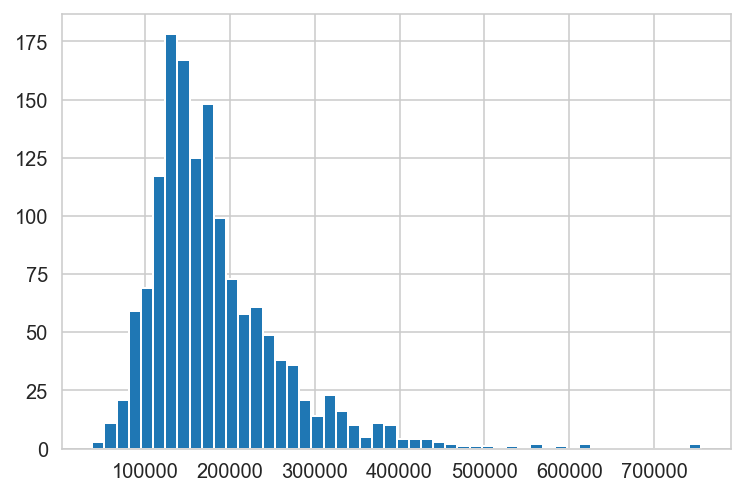

In [12]:
# the sale price value is right skewed 

plt.hist(residential.SalePrice, bins=50)

In [13]:
# apply the log function to the sale price so that the distribution will be normailised 

log_price = np.log(house.SalePrice)

(array([  2.,   2.,   1.,   0.,   0.,   0.,   2.,   3.,   4.,   3.,   5.,
          1.,   5.,  21.,  22.,  23.,  18.,  29.,  58.,  56.,  65., 100.,
        122.,  93.,  90.,  82., 108.,  91.,  64.,  55.,  58.,  51.,  46.,
         42.,  23.,  29.,  22.,  13.,  13.,  13.,   7.,   5.,   4.,   1.,
          2.,   2.,   2.,   0.,   0.,   2.]),
 array([10.46024211, 10.52172673, 10.58321134, 10.64469596, 10.70618058,
        10.7676652 , 10.82914982, 10.89063444, 10.95211906, 11.01360367,
        11.07508829, 11.13657291, 11.19805753, 11.25954215, 11.32102677,
        11.38251138, 11.443996  , 11.50548062, 11.56696524, 11.62844986,
        11.68993448, 11.75141909, 11.81290371, 11.87438833, 11.93587295,
        11.99735757, 12.05884219, 12.12032681, 12.18181142, 12.24329604,
        12.30478066, 12.36626528, 12.4277499 , 12.48923452, 12.55071913,
        12.61220375, 12.67368837, 12.73517299, 12.79665761, 12.85814223,
        12.91962684, 12.98111146, 13.04259608, 13.1040807 , 13.16556532,
 

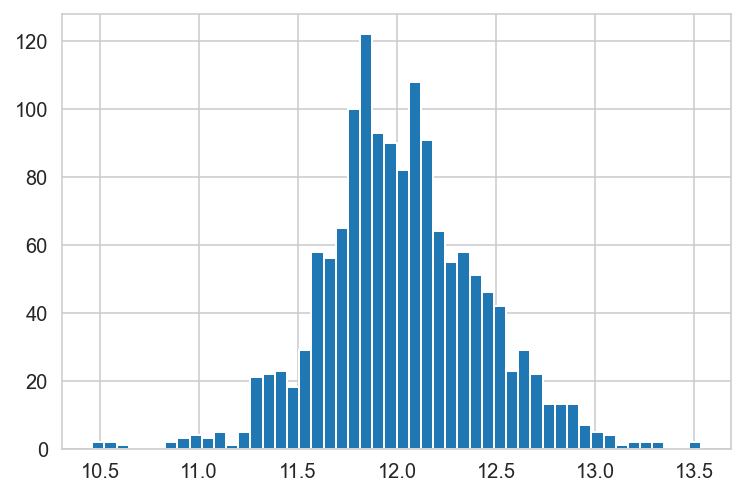

In [14]:
plt.hist(log_price, bins=50)

### Check the columns

In [15]:
residential.columns

Index(['MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope',
       'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle',
       'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'RoofStyle',
       'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'MasVnrArea',
       'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond',
       'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2',
       'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating', 'HeatingQC',
       'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual', 'TotRmsAbvGrd',
       'Functional', 'Fireplaces', 'GarageType', 'GarageYrBlt', 'GarageFinish',
       'GarageCars', 'GarageArea', 'GarageQual', 'GarageCond', 'PavedDrive',
       'WoodDeckSF', 'OpenPorchSF'

In [16]:
# identify fixed variables 

fixed = ['MSZoning','LotArea','Street', 'LotShape', 'LandContour', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2','YearBuilt','YearRemodAdd', 'ExterQual','ExterCond','Foundation', 'MiscVal', 'MoSold', 'YrSold','SaleType', 'SaleCondition']

In [17]:
fixed_residential = residential[fixed]

In [18]:
fixed_residential

,MSZoning,LotArea,Street,LotShape,LandContour,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,YearBuilt,YearRemodAdd,ExterQual,ExterCond,Foundation,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,RL,8450,Pave,Reg,Lvl,Inside,Gtl,CollgCr,Norm,Norm,2003,2003,Gd,TA,PConc,0,2,2008,WD,Normal
1,RL,9600,Pave,Reg,Lvl,FR2,Gtl,Veenker,Feedr,Norm,1976,1976,TA,TA,CBlock,0,5,2007,WD,Normal
2,RL,11250,Pave,IR1,Lvl,Inside,Gtl,CollgCr,Norm,Norm,2001,2002,Gd,TA,PConc,0,9,2008,WD,Normal
3,RL,9550,Pave,IR1,Lvl,Corner,Gtl,Crawfor,Norm,Norm,1915,1970,TA,TA,BrkTil,0,2,2006,WD,Abnorml
4,RL,14260,Pave,IR1,Lvl,FR2,Gtl,NoRidge,Norm,Norm,2000,2000,Gd,TA,PConc,0,12,2008,WD,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,RL,7917,Pave,Reg,Lvl,Inside,Gtl,Gilbert,Norm,Norm,1999,2000,TA,TA,PConc,0,8,2007,WD,Normal
1456,RL,13175,Pave,Reg,Lvl,Inside,Gtl,NWAmes,Norm,Norm,1978,1988,TA,TA,CBlock,0,2,2010,WD,Normal
1457,RL,9042,Pave,Reg,Lvl,Inside,Gtl,Crawfor,Norm,Norm,1941,2006,Ex,Gd,Stone,2500,5,2010,WD,Normal
1458,RL,9717,Pave,Reg,Lvl,Inside,Gtl,NAmes,Norm,Norm,1950,1996,TA,TA,CBlock,0,4,2010,WD,Normal


In [19]:
# check the data types for fixed variables 

fixed_residential.dtypes

MSZoning         object
LotArea           int64
Street           object
LotShape         object
LandContour      object
LotConfig        object
LandSlope        object
Neighborhood     object
Condition1       object
Condition2       object
YearBuilt         int64
YearRemodAdd      int64
ExterQual        object
ExterCond        object
Foundation       object
MiscVal           int64
MoSold            int64
YrSold            int64
SaleType         object
SaleCondition    object
dtype: object

In [20]:
# Separate the categorical data in fixed variables 

fixed_categorical = fixed_residential.select_dtypes(include='O')

In [21]:
# Count non-na values for each fixed variables 

fixed_categorical.nunique()

MSZoning          4
Street            2
LotShape          4
LandContour       4
LotConfig         5
LandSlope         3
Neighborhood     25
Condition1        9
Condition2        8
ExterQual         4
ExterCond         5
Foundation        6
SaleType          9
SaleCondition     6
dtype: int64

In [22]:
# inspect all categorical data in fixed variables 

fixed_categorical

,MSZoning,Street,LotShape,LandContour,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,ExterQual,ExterCond,Foundation,SaleType,SaleCondition
0,RL,Pave,Reg,Lvl,Inside,Gtl,CollgCr,Norm,Norm,Gd,TA,PConc,WD,Normal
1,RL,Pave,Reg,Lvl,FR2,Gtl,Veenker,Feedr,Norm,TA,TA,CBlock,WD,Normal
2,RL,Pave,IR1,Lvl,Inside,Gtl,CollgCr,Norm,Norm,Gd,TA,PConc,WD,Normal
3,RL,Pave,IR1,Lvl,Corner,Gtl,Crawfor,Norm,Norm,TA,TA,BrkTil,WD,Abnorml
4,RL,Pave,IR1,Lvl,FR2,Gtl,NoRidge,Norm,Norm,Gd,TA,PConc,WD,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,RL,Pave,Reg,Lvl,Inside,Gtl,Gilbert,Norm,Norm,TA,TA,PConc,WD,Normal
1456,RL,Pave,Reg,Lvl,Inside,Gtl,NWAmes,Norm,Norm,TA,TA,CBlock,WD,Normal
1457,RL,Pave,Reg,Lvl,Inside,Gtl,Crawfor,Norm,Norm,Ex,Gd,Stone,WD,Normal
1458,RL,Pave,Reg,Lvl,Inside,Gtl,NAmes,Norm,Norm,TA,TA,CBlock,WD,Normal


In [23]:
# replace the null value in categorical data with 'nan'


fixed_categorical['MSZoning'] = fixed_categorical['MSZoning'].fillna('nan')
fixed_categorical['Street'] = fixed_categorical['Street'].fillna('nan')
fixed_categorical['LotShape'] = fixed_categorical['LotShape'].fillna('nan')
fixed_categorical['LandContour'] = fixed_categorical['LandContour'].fillna('nan')
fixed_categorical['LotConfig'] = fixed_categorical['LotConfig'].fillna('nan')
fixed_categorical['LandSlope'] = fixed_categorical['LandSlope'].fillna('nan')
fixed_categorical['Neighborhood'] = fixed_categorical['Neighborhood'].fillna('nan')
fixed_categorical['Condition1'] = fixed_categorical['Condition1'].fillna('nan')
fixed_categorical['Condition2'] = fixed_categorical['Condition2'].fillna('nan')
fixed_categorical['ExterQual'] = fixed_categorical['ExterQual'].fillna('nan')
fixed_categorical['ExterCond'] = fixed_categorical['ExterCond'].fillna('nan')
fixed_categorical['Foundation'] = fixed_categorical['Foundation'].fillna('nan')
fixed_categorical['SaleType'] = fixed_categorical['SaleType'].fillna('nan')
#fixed_categorical['SaleCondition'] = fixed_categorical['SaleCondition'].fillna('nan')

<ipython-input-23-f1380f5a7592>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fixed_categorical['MSZoning'] = fixed_categorical['MSZoning'].fillna('nan')
<ipython-input-23-f1380f5a7592>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fixed_categorical['Street'] = fixed_categorical['Street'].fillna('nan')
<ipython-input-23-f1380f5a7592>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in

In [27]:
# import patsy library 
import patsy

In [28]:
# split the data Yearsold in 2010 as the test data and the rest as the training data 

test = residential.YrSold == 2010

train = residential.YrSold != 2010

In [29]:
# define the formula y = Saleprice and x = fixed variables 

fixed_stats = '''
SalePrice ~ MSZoning + LotArea + Street + LotShape + LandContour + 
LotConfig + LandSlope + Neighborhood + Condition1 + Condition2 + YearBuilt + 
YearRemodAdd + ExterQual + ExterCond + Foundation + MiscVal + MoSold + YrSold + SaleType + SaleCondition -1

'''

fixed_stats

'\nSalePrice ~ MSZoning + LotArea + Street + LotShape + LandContour + \nLotConfig + LandSlope + Neighborhood + Condition1 + Condition2 + YearBuilt + \nYearRemodAdd + ExterQual + ExterCond + Foundation + MiscVal + MoSold + YrSold + SaleType + SaleCondition -1\n\n'

In [30]:
y, X = patsy.dmatrices(fixed_stats, data = residential, return_type='dataframe')

In [31]:
y = np.log(y)
y =y.values.ravel()

print(y.shape, X.shape)


(1450,) (1450, 87)


In [32]:
# check all X variables in the dataframe
X

,MSZoning[FV],MSZoning[RH],MSZoning[RL],MSZoning[RM],Street[T.Pave],LotShape[T.IR2],LotShape[T.IR3],LotShape[T.Reg],LandContour[T.HLS],LandContour[T.Low],...,SaleCondition[T.Alloca],SaleCondition[T.Family],SaleCondition[T.Normal],SaleCondition[T.Partial],LotArea,YearBuilt,YearRemodAdd,MiscVal,MoSold,YrSold
0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,8450.0,2003.0,2003.0,0.0,2.0,2008.0
1,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,9600.0,1976.0,1976.0,0.0,5.0,2007.0
2,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,11250.0,2001.0,2002.0,0.0,9.0,2008.0
3,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,9550.0,1915.0,1970.0,0.0,2.0,2006.0
4,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,14260.0,2000.0,2000.0,0.0,12.0,2008.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,7917.0,1999.0,2000.0,0.0,8.0,2007.0
1456,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,13175.0,1978.0,1988.0,0.0,2.0,2010.0
1457,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,9042.0,1941.0,2006.0,2500.0,5.0,2010.0
1458,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,9717.0,1950.0,1996.0,0.0,4.0,2010.0


In [33]:
# standardize the formula

from sklearn.preprocessing import StandardScaler


ss = StandardScaler()
Xs = ss.fit_transform(X)

In [34]:
X_train, X_test = X[train], X[test]

y_train, y_test = y[train], y[test]

In [35]:
X_train_s = ss.fit_transform(X_train)

In [36]:
X_test_s = ss.transform(X_test)

In [37]:
X_train_s, X_test_s

(array([[-0.2160626 , -0.11259791,  0.51511798, ..., -0.07562998,
         -1.68778009,  0.42876315],
        [-0.2160626 , -0.11259791,  0.51511798, ..., -0.07562998,
         -0.58182404, -0.46078117],
        [-0.2160626 , -0.11259791,  0.51511798, ..., -0.07562998,
          0.89278403,  0.42876315],
        ...,
        [ 4.6282883 , -0.11259791, -1.94130284, ..., -0.07562998,
          1.26143605,  1.31830747],
        [-0.2160626 , -0.11259791,  0.51511798, ..., -0.07562998,
          0.52413202, -0.46078117],
        [-0.2160626 , -0.11259791,  0.51511798, ..., -0.07562998,
         -0.21317202,  0.42876315]]),
 array([[-0.2160626 , -0.11259791,  0.51511798, ...,  1.29453158,
         -1.31912807,  2.20785179],
        [-0.2160626 , -0.11259791,  0.51511798, ..., -0.07562998,
         -0.58182404,  2.20785179],
        [-0.2160626 , -0.11259791,  0.51511798, ..., -0.07562998,
         -0.58182404,  2.20785179],
        ...,
        [-0.2160626 , -0.11259791,  0.51511798, ..., -

In [38]:
X_train_s.shape

(1278, 87)

In [39]:
# import Lasso, cross validation libraries to create the models 


from sklearn.linear_model import Lasso, LassoCV
from sklearn.model_selection import cross_val_score

In [40]:
lasso_cv = LassoCV(n_alphas=500, cv=10, verbose=1)
lasso_cv.fit(X_train_s, y_train)


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
.......................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

LassoCV(cv=10, n_alphas=500, verbose=1)

In [41]:
lasso_cv.score(X_test_s, y_test)

0.7700264519967905

In [42]:
lasso_cv.alpha_

0.0018744696053681722

In [43]:
best_lasso = Lasso(alpha = lasso_cv.alpha_)
best_lasso.fit(X_train_s, y_train)

Lasso(alpha=0.0018744696053681722)

In [44]:
best_lasso.score(X_test_s, y_test)

0.7700264519967905

In [45]:
lasso_coefs = pd.DataFrame({'variable':X.columns,
                            'coef':best_lasso.coef_,
                            'abs_coef':np.abs(best_lasso.coef_)})

lasso_coefs.sort_values('abs_coef', inplace=True, ascending=False)

lasso_coefs.head(20)

,variable,coef,abs_coef
58,ExterQual[T.TA],-0.168928,0.168928
57,ExterQual[T.Gd],-0.097298,0.097298
81,LotArea,0.083503,0.083503
31,Neighborhood[T.NoRidge],0.070794,0.070794
82,YearBuilt,0.062676,0.062676
83,YearRemodAdd,0.061905,0.061905
32,Neighborhood[T.NridgHt],0.061720,0.061720
22,Neighborhood[T.Crawfor],0.046632,0.046632
56,ExterQual[T.Fa],-0.043834,0.043834
38,Neighborhood[T.StoneBr],0.037290,0.037290


In [43]:
optimal_lasso = LassoCV(n_alphas=500, cv=10, verbose=1)
optimal_lasso.fit(Xs, y)

print(optimal_lasso.alpha_)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
.......................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

0.00174824312036459


...............................................................................................................................[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    1.7s finished


<img src="http://imgur.com/l5NasQj.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 2. Determine any value of *changeable* property characteristics unexplained by the *fixed* ones.

---

Now that you have a model that estimates the price of a house based on its static characteristics, we can move forward with part 2 and 3 of the plan: what are the costs/benefits of quality, condition, and renovations?

There are two specific requirements for these estimates:
1. The estimates of effects must be in terms of dollars added or subtracted from the house value. 
2. The effects must be on the variance in price remaining from the first model.

The residuals from the first model (training and testing) represent the variance in price unexplained by the fixed characteristics. Of that variance in price remaining, how much of it can be explained by the easy-to-change aspects of the property?

---

**Your goals:**
1. Evaluate the effect in dollars of the renovate-able features. 
- How would your company use this second model and its coefficients to determine whether they should buy a property or not? Explain how the company can use the two models you have built to determine if they can make money. 
- Investigate how much of the variance in price remaining is explained by these features.
- Do you trust your model? Should it be used to evaluate which properties to buy and fix up?

In [44]:
residential.columns

Index(['MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope',
       'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle',
       'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'RoofStyle',
       'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'MasVnrArea',
       'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond',
       'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2',
       'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating', 'HeatingQC',
       'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual', 'TotRmsAbvGrd',
       'Functional', 'Fireplaces', 'GarageType', 'GarageYrBlt', 'GarageFinish',
       'GarageCars', 'GarageArea', 'GarageQual', 'GarageCond', 'PavedDrive',
       'WoodDeckSF', 'OpenPorchSF'

In [47]:
#renovatable variable 
renovation =  ['MSSubClass', 'LotFrontage', 'Utilities', 'BldgType', 'HouseStyle',
       'OverallQual', 'OverallCond', 'RoofStyle',
       'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'MasVnrArea',
       'BsmtQual', 'BsmtCond',
       'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2',
       'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating', 'HeatingQC',
       'CentralAir', 'Electrical', 'LowQualFinSF',
       'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual', 'TotRmsAbvGrd',
       'Functional', 'Fireplaces', 'GarageType', 'GarageYrBlt', 'GarageFinish',
       'GarageCars', 'GarageArea', 'GarageQual', 'GarageCond', 'PavedDrive',
       'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch',
       'ScreenPorch']


In [48]:
renovation_residential = residential[renovation]

In [49]:
renovation_residential.nunique()

MSSubClass        15
LotFrontage      110
Utilities          2
BldgType           5
HouseStyle         8
OverallQual       10
OverallCond        9
RoofStyle          6
RoofMatl           8
Exterior1st       15
Exterior2nd       16
MasVnrType         4
MasVnrArea       327
BsmtQual           4
BsmtCond           4
BsmtExposure       4
BsmtFinType1       6
BsmtFinSF1       636
BsmtFinType2       6
BsmtFinSF2       144
BsmtUnfSF        776
TotalBsmtSF      719
Heating            6
HeatingQC          5
CentralAir         2
Electrical         5
LowQualFinSF      23
GrLivArea        858
BsmtFullBath       4
BsmtHalfBath       3
FullBath           4
HalfBath           3
BedroomAbvGr       8
KitchenAbvGr       4
KitchenQual        4
TotRmsAbvGrd      12
Functional         7
Fireplaces         4
GarageType         6
GarageYrBlt       96
GarageFinish       3
GarageCars         5
GarageArea       440
GarageQual         5
GarageCond         5
PavedDrive         3
WoodDeckSF       273
OpenPorchSF  

In [50]:
# convert all null values with nan

renovation_residential['MSSubClass'] = renovation_residential['MSSubClass'].fillna('nan')
renovation_residential['LotFrontage'] = renovation_residential['LotFrontage'].fillna('nan')
renovation_residential['Utilities'] = renovation_residential['Utilities'].fillna('nan')
renovation_residential['BldgType'] = renovation_residential['BldgType'].fillna('nan')
renovation_residential['HouseStyle'] = renovation_residential['HouseStyle'].fillna('nan')
renovation_residential['OverallQual'] = renovation_residential['OverallQual'].fillna('nan')
renovation_residential['OverallCond'] = renovation_residential['OverallCond'].fillna('nan')
renovation_residential['RoofStyle'] = renovation_residential['RoofStyle'].fillna('nan')
renovation_residential['RoofMatl'] = renovation_residential['RoofMatl'].fillna('nan')
renovation_residential['Exterior1st'] = renovation_residential['Exterior1st'].fillna('nan')
renovation_residential['Exterior2nd'] = renovation_residential['Exterior2nd'].fillna('nan')
renovation_residential['MasVnrType'] = renovation_residential['MasVnrType'].fillna('nan')
renovation_residential['MasVnrArea'] = renovation_residential['MasVnrArea'].fillna('nan')
renovation_residential['BsmtQual'] = renovation_residential['BsmtQual'].fillna('nan')
renovation_residential['BsmtCond'] = renovation_residential['BsmtCond'].fillna('nan')
renovation_residential['BsmtExposure'] = renovation_residential['BsmtExposure'].fillna('nan')
renovation_residential['BsmtFinType1'] = renovation_residential['BsmtFinType1'].fillna('nan')
renovation_residential['BsmtFinSF1'] = renovation_residential['BsmtFinSF1'].fillna('nan')
renovation_residential['BsmtFinType2'] = renovation_residential['BsmtFinType2'].fillna('nan')
renovation_residential['BsmtFinSF2'] = renovation_residential['BsmtFinSF2'].fillna('nan')
renovation_residential['BsmtUnfSF'] = renovation_residential['BsmtUnfSF'].fillna('nan')
renovation_residential['TotalBsmtSF'] = renovation_residential['TotalBsmtSF'].fillna('nan')
renovation_residential['Heating'] = renovation_residential['Heating'].fillna('nan')
renovation_residential['HeatingQC'] = renovation_residential['HeatingQC'].fillna('nan')

renovation_residential['CentralAir'] = renovation_residential['CentralAir'].fillna('nan')
renovation_residential['Electrical'] = renovation_residential['Electrical'].fillna('nan')
renovation_residential['LowQualFinSF'] = renovation_residential['LowQualFinSF'].fillna('nan')
renovation_residential['GrLivArea'] = renovation_residential['GrLivArea'].fillna('nan')
renovation_residential['BsmtFullBath'] = renovation_residential['BsmtFullBath'].fillna('nan')
renovation_residential['BsmtHalfBath'] = renovation_residential['BsmtHalfBath'].fillna('nan')
renovation_residential['FullBath'] = renovation_residential['FullBath'].fillna('nan')
renovation_residential['HalfBath'] = renovation_residential['HalfBath'].fillna('nan')
renovation_residential['BedroomAbvGr'] = renovation_residential['BedroomAbvGr'].fillna('nan')
renovation_residential['KitchenAbvGr'] = renovation_residential['KitchenAbvGr'].fillna('nan')
renovation_residential['KitchenQual'] = renovation_residential['KitchenQual'].fillna('nan')
renovation_residential['TotRmsAbvGrd'] = renovation_residential['TotRmsAbvGrd'].fillna('nan')
renovation_residential['Functional'] = renovation_residential['Functional'].fillna('nan')
renovation_residential['Fireplaces'] = renovation_residential['Fireplaces'].fillna('nan')

renovation_residential['GarageType'] = renovation_residential['GarageType'].fillna('nan')
renovation_residential['GarageYrBlt'] = renovation_residential['GarageYrBlt'].fillna('nan')
renovation_residential['GarageFinish'] = renovation_residential['GarageFinish'].fillna('nan')
renovation_residential['GarageCars'] = renovation_residential['GarageCars'].fillna('nan')
renovation_residential['GarageArea'] = renovation_residential['GarageArea'].fillna('nan')
renovation_residential['GarageQual'] = renovation_residential['GarageQual'].fillna('nan')
renovation_residential['GarageCond'] = renovation_residential['GarageCond'].fillna('nan')
renovation_residential['PavedDrive'] = renovation_residential['PavedDrive'].fillna('nan')


renovation_residential['WoodDeckSF'] = renovation_residential['WoodDeckSF'].fillna('nan')
renovation_residential['OpenPorchSF'] = renovation_residential['OpenPorchSF'].fillna('nan')
renovation_residential['EnclosedPorch'] = renovation_residential['EnclosedPorch'].fillna('nan')
renovation_residential['ScreenPorch'] = renovation_residential['ScreenPorch'].fillna('nan')

<ipython-input-50-9d764508b85d>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  renovation_residential['MSSubClass'] = renovation_residential['MSSubClass'].fillna('nan')
<ipython-input-50-9d764508b85d>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  renovation_residential['LotFrontage'] = renovation_residential['LotFrontage'].fillna('nan')
<ipython-input-50-9d764508b85d>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] =

In [51]:
renovation_residential

,MSSubClass,LotFrontage,Utilities,BldgType,HouseStyle,OverallQual,OverallCond,RoofStyle,RoofMatl,Exterior1st,...,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,ScreenPorch
0,60,65,AllPub,1Fam,2Story,7,5,Gable,CompShg,VinylSd,...,RFn,2,548,TA,TA,Y,0,61,0,0
1,20,80,AllPub,1Fam,1Story,6,8,Gable,CompShg,MetalSd,...,RFn,2,460,TA,TA,Y,298,0,0,0
2,60,68,AllPub,1Fam,2Story,7,5,Gable,CompShg,VinylSd,...,RFn,2,608,TA,TA,Y,0,42,0,0
3,70,60,AllPub,1Fam,2Story,7,5,Gable,CompShg,Wd Sdng,...,Unf,3,642,TA,TA,Y,0,35,272,0
4,60,84,AllPub,1Fam,2Story,8,5,Gable,CompShg,VinylSd,...,RFn,3,836,TA,TA,Y,192,84,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,60,62,AllPub,1Fam,2Story,6,5,Gable,CompShg,VinylSd,...,RFn,2,460,TA,TA,Y,0,40,0,0
1456,20,85,AllPub,1Fam,1Story,6,6,Gable,CompShg,Plywood,...,Unf,2,500,TA,TA,Y,349,0,0,0
1457,70,66,AllPub,1Fam,2Story,7,9,Gable,CompShg,CemntBd,...,RFn,1,252,TA,TA,Y,0,60,0,0
1458,20,68,AllPub,1Fam,1Story,5,6,Hip,CompShg,MetalSd,...,Unf,1,240,TA,TA,Y,366,0,112,0


In [52]:
RR2=renovation_residential.copy()

RR2

,MSSubClass,LotFrontage,Utilities,BldgType,HouseStyle,OverallQual,OverallCond,RoofStyle,RoofMatl,Exterior1st,...,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,ScreenPorch
0,60,65,AllPub,1Fam,2Story,7,5,Gable,CompShg,VinylSd,...,RFn,2,548,TA,TA,Y,0,61,0,0
1,20,80,AllPub,1Fam,1Story,6,8,Gable,CompShg,MetalSd,...,RFn,2,460,TA,TA,Y,298,0,0,0
2,60,68,AllPub,1Fam,2Story,7,5,Gable,CompShg,VinylSd,...,RFn,2,608,TA,TA,Y,0,42,0,0
3,70,60,AllPub,1Fam,2Story,7,5,Gable,CompShg,Wd Sdng,...,Unf,3,642,TA,TA,Y,0,35,272,0
4,60,84,AllPub,1Fam,2Story,8,5,Gable,CompShg,VinylSd,...,RFn,3,836,TA,TA,Y,192,84,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,60,62,AllPub,1Fam,2Story,6,5,Gable,CompShg,VinylSd,...,RFn,2,460,TA,TA,Y,0,40,0,0
1456,20,85,AllPub,1Fam,1Story,6,6,Gable,CompShg,Plywood,...,Unf,2,500,TA,TA,Y,349,0,0,0
1457,70,66,AllPub,1Fam,2Story,7,9,Gable,CompShg,CemntBd,...,RFn,1,252,TA,TA,Y,0,60,0,0
1458,20,68,AllPub,1Fam,1Story,5,6,Hip,CompShg,MetalSd,...,Unf,1,240,TA,TA,Y,366,0,112,0


In [53]:
RR2.fillna(value=0)

,MSSubClass,LotFrontage,Utilities,BldgType,HouseStyle,OverallQual,OverallCond,RoofStyle,RoofMatl,Exterior1st,...,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,ScreenPorch
0,60,65,AllPub,1Fam,2Story,7,5,Gable,CompShg,VinylSd,...,RFn,2,548,TA,TA,Y,0,61,0,0
1,20,80,AllPub,1Fam,1Story,6,8,Gable,CompShg,MetalSd,...,RFn,2,460,TA,TA,Y,298,0,0,0
2,60,68,AllPub,1Fam,2Story,7,5,Gable,CompShg,VinylSd,...,RFn,2,608,TA,TA,Y,0,42,0,0
3,70,60,AllPub,1Fam,2Story,7,5,Gable,CompShg,Wd Sdng,...,Unf,3,642,TA,TA,Y,0,35,272,0
4,60,84,AllPub,1Fam,2Story,8,5,Gable,CompShg,VinylSd,...,RFn,3,836,TA,TA,Y,192,84,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,60,62,AllPub,1Fam,2Story,6,5,Gable,CompShg,VinylSd,...,RFn,2,460,TA,TA,Y,0,40,0,0
1456,20,85,AllPub,1Fam,1Story,6,6,Gable,CompShg,Plywood,...,Unf,2,500,TA,TA,Y,349,0,0,0
1457,70,66,AllPub,1Fam,2Story,7,9,Gable,CompShg,CemntBd,...,RFn,1,252,TA,TA,Y,0,60,0,0
1458,20,68,AllPub,1Fam,1Story,5,6,Hip,CompShg,MetalSd,...,Unf,1,240,TA,TA,Y,366,0,112,0


In [54]:
renovation_residential.isna().sum()

MSSubClass       0
LotFrontage      0
Utilities        0
BldgType         0
HouseStyle       0
OverallQual      0
OverallCond      0
RoofStyle        0
RoofMatl         0
Exterior1st      0
Exterior2nd      0
MasVnrType       0
MasVnrArea       0
BsmtQual         0
BsmtCond         0
BsmtExposure     0
BsmtFinType1     0
BsmtFinSF1       0
BsmtFinType2     0
BsmtFinSF2       0
BsmtUnfSF        0
TotalBsmtSF      0
Heating          0
HeatingQC        0
CentralAir       0
Electrical       0
LowQualFinSF     0
GrLivArea        0
BsmtFullBath     0
BsmtHalfBath     0
FullBath         0
HalfBath         0
BedroomAbvGr     0
KitchenAbvGr     0
KitchenQual      0
TotRmsAbvGrd     0
Functional       0
Fireplaces       0
GarageType       0
GarageYrBlt      0
GarageFinish     0
GarageCars       0
GarageArea       0
GarageQual       0
GarageCond       0
PavedDrive       0
WoodDeckSF       0
OpenPorchSF      0
EnclosedPorch    0
ScreenPorch      0
dtype: int64

In [55]:
renovation_residential['MasVnrType'] = renovation_residential['MasVnrType'].fillna('nan')
renovation_residential['BsmtQual'] = renovation_residential['BsmtQual'].fillna('nan')
renovation_residential['BsmtCond'] = renovation_residential['BsmtCond'].fillna('nan')
renovation_residential['BsmtExposure'] = renovation_residential['BsmtExposure'].fillna('nan')
renovation_residential['BsmtFinType1'] = renovation_residential['BsmtFinType1'].fillna('nan')
renovation_residential['BsmtFinType2'] = renovation_residential['BsmtFinType2'].fillna('nan')
renovation_residential['Electrical'] = renovation_residential['Electrical'].fillna('nan')
renovation_residential['GarageType'] = renovation_residential['GarageType'].fillna('nan')
renovation_residential['GarageFinish'] = renovation_residential['GarageFinish'].fillna('nan')
renovation_residential['GarageQual'] = renovation_residential['GarageQual'].fillna('nan')
renovation_residential['GarageCond'] = renovation_residential['GarageCond'].fillna('nan')

<ipython-input-55-8632c44118c8>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  renovation_residential['MasVnrType'] = renovation_residential['MasVnrType'].fillna('nan')
<ipython-input-55-8632c44118c8>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  renovation_residential['BsmtQual'] = renovation_residential['BsmtQual'].fillna('nan')
<ipython-input-55-8632c44118c8>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value

In [56]:
renovation_residential['MasVnrType'].value_counts()

None       854
BrkFace    445
Stone      128
BrkCmn      15
nan          8
Name: MasVnrType, dtype: int64

In [57]:
renovation_residential['GarageCond'].value_counts()

TA     1319
nan      79
Fa       34
Gd        9
Po        7
Ex        2
Name: GarageCond, dtype: int64

In [58]:
renovation_residential.isna().sum()

MSSubClass       0
LotFrontage      0
Utilities        0
BldgType         0
HouseStyle       0
OverallQual      0
OverallCond      0
RoofStyle        0
RoofMatl         0
Exterior1st      0
Exterior2nd      0
MasVnrType       0
MasVnrArea       0
BsmtQual         0
BsmtCond         0
BsmtExposure     0
BsmtFinType1     0
BsmtFinSF1       0
BsmtFinType2     0
BsmtFinSF2       0
BsmtUnfSF        0
TotalBsmtSF      0
Heating          0
HeatingQC        0
CentralAir       0
Electrical       0
LowQualFinSF     0
GrLivArea        0
BsmtFullBath     0
BsmtHalfBath     0
FullBath         0
HalfBath         0
BedroomAbvGr     0
KitchenAbvGr     0
KitchenQual      0
TotRmsAbvGrd     0
Functional       0
Fireplaces       0
GarageType       0
GarageYrBlt      0
GarageFinish     0
GarageCars       0
GarageArea       0
GarageQual       0
GarageCond       0
PavedDrive       0
WoodDeckSF       0
OpenPorchSF      0
EnclosedPorch    0
ScreenPorch      0
dtype: int64

In [59]:

renovation_f = '~ '+' + '.join(renovation)+' -1'

In [60]:
renovation_f

'~ MSSubClass + LotFrontage + Utilities + BldgType + HouseStyle + OverallQual + OverallCond + RoofStyle + RoofMatl + Exterior1st + Exterior2nd + MasVnrType + MasVnrArea + BsmtQual + BsmtCond + BsmtExposure + BsmtFinType1 + BsmtFinSF1 + BsmtFinType2 + BsmtFinSF2 + BsmtUnfSF + TotalBsmtSF + Heating + HeatingQC + CentralAir + Electrical + LowQualFinSF + GrLivArea + BsmtFullBath + BsmtHalfBath + FullBath + HalfBath + BedroomAbvGr + KitchenAbvGr + KitchenQual + TotRmsAbvGrd + Functional + Fireplaces + GarageType + GarageYrBlt + GarageFinish + GarageCars + GarageArea + GarageQual + GarageCond + PavedDrive + WoodDeckSF + OpenPorchSF + EnclosedPorch + ScreenPorch -1'

In [61]:
RR2.columns

Index(['MSSubClass', 'LotFrontage', 'Utilities', 'BldgType', 'HouseStyle',
       'OverallQual', 'OverallCond', 'RoofStyle', 'RoofMatl', 'Exterior1st',
       'Exterior2nd', 'MasVnrType', 'MasVnrArea', 'BsmtQual', 'BsmtCond',
       'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2',
       'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating', 'HeatingQC',
       'CentralAir', 'Electrical', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath',
       'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr',
       'KitchenQual', 'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond', 'PavedDrive', 'WoodDeckSF', 'OpenPorchSF',
       'EnclosedPorch', 'ScreenPorch'],
      dtype='object')

In [62]:
X_two = patsy.dmatrix(renovation_f, data = residential, return_type='dataframe',NA_action=patsy.NAAction(NA_types=[]))

In [63]:
X_two.describe()

,Utilities[AllPub],Utilities[NoSeWa],BldgType[T.2fmCon],BldgType[T.Duplex],BldgType[T.Twnhs],BldgType[T.TwnhsE],HouseStyle[T.1.5Unf],HouseStyle[T.1Story],HouseStyle[T.2.5Fin],HouseStyle[T.2.5Unf],...,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,ScreenPorch
count,1450.000000,1450.000000,1450.000000,1450.000000,1450.000000,1450.000000,1450.000000,1450.000000,1450.000000,1450.000000,...,1450.000000,1450.000000,1450.000000,1371.000000,1450.000000,1450.000000,1450.000000,1450.000000,1450.000000,1450.000000
mean,0.999310,0.000690,0.020690,0.035862,0.029655,0.078621,0.009655,0.497931,0.005517,0.006897,...,1.046207,6.522069,0.616552,1978.627279,1.770345,473.277931,94.826897,46.537931,21.536552,15.096552
std,0.026261,0.026261,0.142392,0.186010,0.169693,0.269239,0.097819,0.500168,0.074099,0.082787,...,0.219643,1.625324,0.644991,24.592779,0.745136,212.687621,125.560863,65.222761,60.838826,55.893399
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,2.000000,0.000000,1906.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.000000,5.000000,0.000000,1961.500000,1.000000,336.000000,0.000000,0.000000,0.000000,0.000000
50%,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.000000,6.000000,1.000000,1980.000000,2.000000,480.000000,0.000000,25.000000,0.000000,0.000000
75%,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,...,1.000000,7.000000,1.000000,2002.000000,2.000000,576.000000,168.000000,68.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,3.000000,14.000000,3.000000,2010.000000,4.000000,1418.000000,857.000000,547.000000,552.000000,480.000000


In [64]:
test = residential.YrSold == 2010

train = residential.YrSold != 2010

In [65]:
X_two_train, X_two_test = X_two[train], X_two[test]

In [66]:
X_two_train.isnull()

,Utilities[AllPub],Utilities[NoSeWa],BldgType[T.2fmCon],BldgType[T.Duplex],BldgType[T.Twnhs],BldgType[T.TwnhsE],HouseStyle[T.1.5Unf],HouseStyle[T.1Story],HouseStyle[T.2.5Fin],HouseStyle[T.2.5Unf],...,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,ScreenPorch
0,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1452,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1453,False,False,False,False,False,False,False,False,False,False,...,False,False,False,True,False,False,False,False,False,False
1454,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1455,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [67]:
X_two_train.shape

(1278, 153)

In [68]:
X_two_test.shape


(172, 153)

In [69]:
y_train_res = y_train - best_lasso.predict(X_train_s) 
y_test_res = y_test - best_lasso.predict(X_test_s)

In [70]:
renovation_residential['LotFrontage'] = renovation_residential['LotFrontage'].fillna(value=0)
renovation_residential['MasVnrArea'] = renovation_residential['MasVnrArea'].fillna(value=0)
renovation_residential['GarageYrBlt'] = renovation_residential['GarageYrBlt'].fillna(value=0)

<ipython-input-70-b74cb09e3fc5>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  renovation_residential['LotFrontage'] = renovation_residential['LotFrontage'].fillna(value=0)
<ipython-input-70-b74cb09e3fc5>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  renovation_residential['MasVnrArea'] = renovation_residential['MasVnrArea'].fillna(value=0)
<ipython-input-70-b74cb09e3fc5>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexe

In [71]:
X_two = patsy.dmatrix(renovation_f, data = renovation_residential, return_type='dataframe',NA_action=patsy.NAAction(NA_types=[]))

In [72]:
X_two_train, X_two_test = X_two[train], X_two[test]

In [73]:
X_two_train_s = ss.fit_transform(X_two_train)

X_two_test_s = ss.transform(X_two_test)

In [74]:
y_train_res.shape

(1278,)

In [75]:
y_test_res.shape

(172,)

In [76]:
lasso_cv = LassoCV(n_alphas=100, cv=10, verbose=1)
lasso_cv.fit(X_two_train_s, y_train_res)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
................................................................................................./Users/anita/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:525: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0051240523708102614, tolerance: 0.004971402194877253
  model = cd_fast.enet_coordinate_descent_gram(
............................................................................................................................................................................................................................................................................................................/Users/anita/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:525: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Dual

LassoCV(cv=10, verbose=1)

In [77]:
lasso_cv.score(X_two_test_s, y_test_res)

0.2731231624821904

In [78]:
# the most Influencing factors for the house price are "OverallQual,GrLivArea, GarageCars,GarageArea, TotalBsmtSF, 1stFlrSF, FullBath, TotRmsAbvGrd,YearBuilt"

# it is worth to dig deeper with these variables 

house.corr().SalePrice.sort_values(ascending=False).head(10)

SalePrice       1.000000
OverallQual     0.790982
GrLivArea       0.708624
GarageCars      0.640409
GarageArea      0.623431
TotalBsmtSF     0.613581
1stFlrSF        0.605852
FullBath        0.560664
TotRmsAbvGrd    0.533723
YearBuilt       0.522897
Name: SalePrice, dtype: float64

<img src="http://imgur.com/GCAf1UX.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 3. What property characteristics predict an "abnormal" sale?

---

The `SaleCondition` feature indicates the circumstances of the house sale. From the data file, we can see that the possibilities are:

       Normal	Normal Sale
       Abnorml	Abnormal Sale -  trade, foreclosure, short sale
       AdjLand	Adjoining Land Purchase
       Alloca	Allocation - two linked properties with separate deeds, typically condo with a garage unit	
       Family	Sale between family members
       Partial	Home was not completed when last assessed (associated with New Homes)
       
One of the executives at your company has an "in" with higher-ups at the major regional bank. His friends at the bank have made him a proposal: if he can reliably indicate what features, if any, predict "abnormal" sales (foreclosures, short sales, etc.), then in return the bank will give him first dibs on the pre-auction purchase of those properties (at a dirt-cheap price).

He has tasked you with determining (and adequately validating) which features of a property predict this type of sale. 

---

**Your task:**
1. Determine which features predict the `Abnorml` category in the `SaleCondition` feature.
- Justify your results.

This is a challenging task that tests your ability to perform classification analysis in the face of severe class imbalance. You may find that simply running a classifier on the full dataset to predict the category ends up useless: when there is bad class imbalance classifiers often tend to simply guess the majority class.

It is up to you to determine how you will tackle this problem. I recommend doing some research to find out how others have dealt with the problem in the past. Make sure to justify your solution. Don't worry about it being "the best" solution, but be rigorous.

Be sure to indicate which features are predictive (if any) and whether they are positive or negative predictors of abnormal sales.

In [77]:
house.SaleCondition.value_counts()

Normal     1198
Partial     125
Abnorml     101
Family       20
Alloca       12
AdjLand       4
Name: SaleCondition, dtype: int64